In [1]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# imports and plotting settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,5)

In [3]:
# parsing the Date column to datetime
df = pd.read_csv("../data/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv", dayfirst=True)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)
df.head()


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,2019-07-01,15987,9962,407,21223,3715,NaN
1,2019-07-02,16895,10656,409,21715,3993,NaN
2,2019-07-03,16613,10658,427,22025,3638,NaN
3,2019-07-04,16604,10445,437,21868,3576,NaN
4,2019-07-05,16040,10532,400,20697,2856,NaN


In [4]:
# Data health check based on shape, missing dates, dtypes and null values
print("rows,cols:", df.shape)
print(df.dtypes)
print(df.isnull().sum())

rows,cols: (1918, 7)
Date            datetime64[ns]
Local Route              int64
Light Rail               int64
Peak Service             int64
Rapid Route              int64
School                   int64
Other                  float64
dtype: object
Date             0
Local Route      0
Light Rail       0
Peak Service     0
Rapid Route      0
School           0
Other           20
dtype: int64


In [5]:
# aggregating a total passengers column and setting Date as index
service_cols = ['Local Route','Light Rail','Peak Service','Rapid Route','School','Other']
df[service_cols] = df[service_cols].apply(pd.to_numeric, errors='coerce')  # convert
df['total_journeys'] = df[service_cols].sum(axis=1)
df = df.set_index('Date')
df = df[~df.index.isna()]  # drop rows without date
df = df.sort_index()
df[['total_journeys'] + service_cols].head()

,total_journeys,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
Date,,,,,,,
2019-07-01,51294.0,15987,9962,407,21223,3715,NaN
2019-07-02,53668.0,16895,10656,409,21715,3993,NaN
2019-07-03,53361.0,16613,10658,427,22025,3638,NaN
2019-07-04,52930.0,16604,10445,437,21868,3576,NaN
2019-07-05,50525.0,16040,10532,400,20697,2856,NaN


In [6]:
# resample to daily index and fill missing days with forward-fill then zero where still NA
daily = df[['total_journeys'] + service_cols].resample('D').sum()
daily = daily.ffill().fillna(0)  # simple and safe for this exercise
daily.head()

,total_journeys,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
Date,,,,,,,
2019-07-01,51294.0,15987,9962,407,21223,3715,0.0
2019-07-02,53668.0,16895,10656,409,21715,3993,0.0
2019-07-03,53361.0,16613,10658,427,22025,3638,0.0
2019-07-04,52930.0,16604,10445,437,21868,3576,0.0
2019-07-05,50525.0,16040,10532,400,20697,2856,0.0


In [7]:
# --- CLEANING BLOCK START ---
# ensure service columns exist and are numeric
service_cols = ['Local Route','Light Rail','Peak Service','Rapid Route','School','Other']

# keep only the ones that exist in df
service_cols = [c for c in service_cols if c in df.columns]

# convert to numeric safely
df[service_cols] = df[service_cols].apply(pd.to_numeric, errors='coerce')

# create total_journeys if missing
if 'total_journeys' not in df.columns:
    df['total_journeys'] = df[service_cols].sum(axis=1)

print("Service columns used:", service_cols)
print(df[['total_journeys'] + service_cols].head())
# --- CLEANING BLOCK END ---


Service columns used: ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
            total_journeys  Local Route  Light Rail  Peak Service  \
Date                                                                
2019-07-01         51294.0        15987        9962           407   
2019-07-02         53668.0        16895       10656           409   
2019-07-03         53361.0        16613       10658           427   
2019-07-04         52930.0        16604       10445           437   
2019-07-05         50525.0        16040       10532           400   

            Rapid Route  School  Other  
Date                                    
2019-07-01        21223    3715    NaN  
2019-07-02        21715    3993    NaN  
2019-07-03        22025    3638    NaN  
2019-07-04        21868    3576    NaN  
2019-07-05        20697    2856    NaN  


In [8]:
# ensure Date exists and convert to datetime
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.set_index('Date')
else:
    df.index = pd.to_datetime(df.index, dayfirst=True, errors='coerce')

df = df.sort_index()

# resample to daily frequency
daily = df.resample('D').sum()

# forward-fill missing days (safe method)
daily = daily.ffill().fillna(0)

# preview
daily.head()


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,total_journeys
Date,,,,,,,
2019-07-01,15987,9962,407,21223,3715,0.0,51294.0
2019-07-02,16895,10656,409,21715,3993,0.0,53668.0
2019-07-03,16613,10658,427,22025,3638,0.0,53361.0
2019-07-04,16604,10445,437,21868,3576,0.0,52930.0
2019-07-05,16040,10532,400,20697,2856,0.0,50525.0


In [9]:
# save cleaned daily dataset for Prophet/XGBoost notebooks
daily.to_csv("../data/daily_processed.csv")

print("Saved cleaned dataset as data/daily_processed.csv")
print("Shape:", daily.shape)


Saved cleaned dataset as data/daily_processed.csv
Shape: (1918, 7)


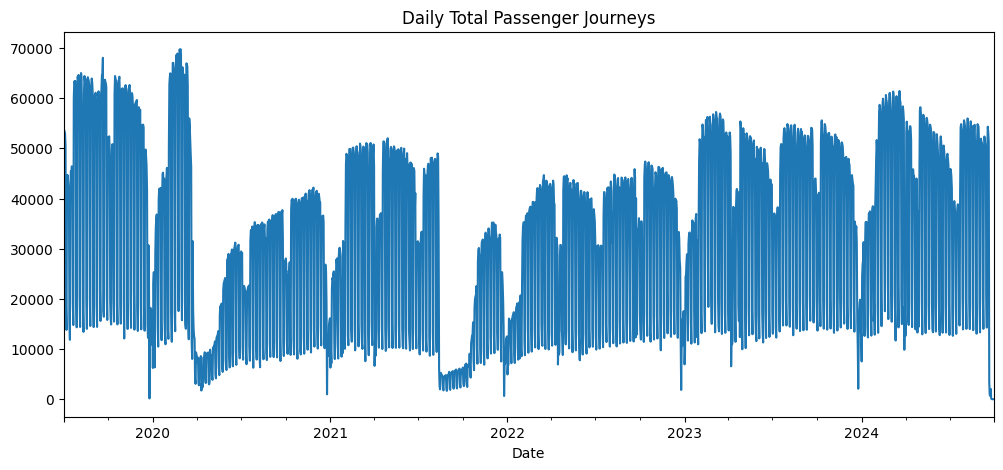

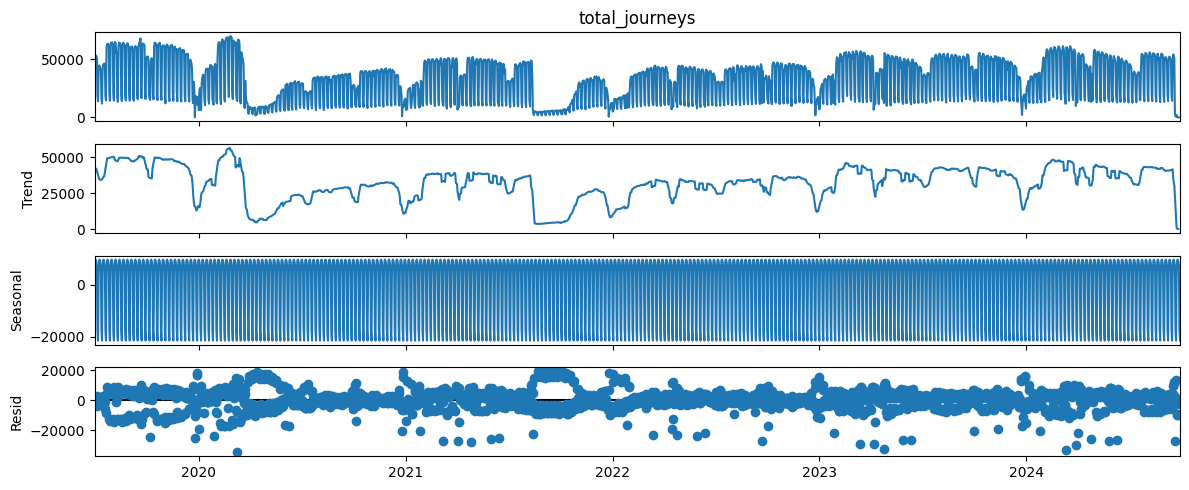

In [10]:
# plot total series and seasonal decomposition (weekly seasonality)
daily['total_journeys'].plot(title="Daily Total Passenger Journeys")
plt.show()
decomp = seasonal_decompose(daily['total_journeys'], model='additive', period=7)
decomp.plot()
plt.show()

In [11]:
# weekday patterns and service contribution ratios
daily['weekday'] = daily.index.day_name()
weekday_avg = daily.groupby('weekday')['total_journeys'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
print("Avg by weekday:\n", weekday_avg)
service_share = (daily[service_cols].sum() / daily['total_journeys'].sum()).sort_values(ascending=False)
print("\nService type share:\n", service_share)
# weekday average shows which day is busiest,to find highest priorityy

Avg by weekday:
 weekday
Monday       36139.364964
Tuesday      41572.350365
Wednesday    41836.244526
Thursday     41104.802920
Friday       39379.200730
Saturday     14931.828467
Sunday       10851.091241
Name: total_journeys, dtype: float64

Service type share:
 Rapid Route     0.390499
Local Route     0.306622
Light Rail      0.223051
School          0.072931
Peak Service    0.005567
Other           0.001331
dtype: float64


In [12]:
# time-based train/test split and a naive rolling-7 baseline to track the model performance for future use
test_days = 30
train = daily['total_journeys'][:-test_days]
test = daily['total_journeys'][-test_days:]
baseline_pred = train.rolling(window=7, min_periods=1).mean().iloc[-test_days:].values
print("Baseline MAE:", mean_absolute_error(test, baseline_pred))

Baseline MAE: 22749.25238095238


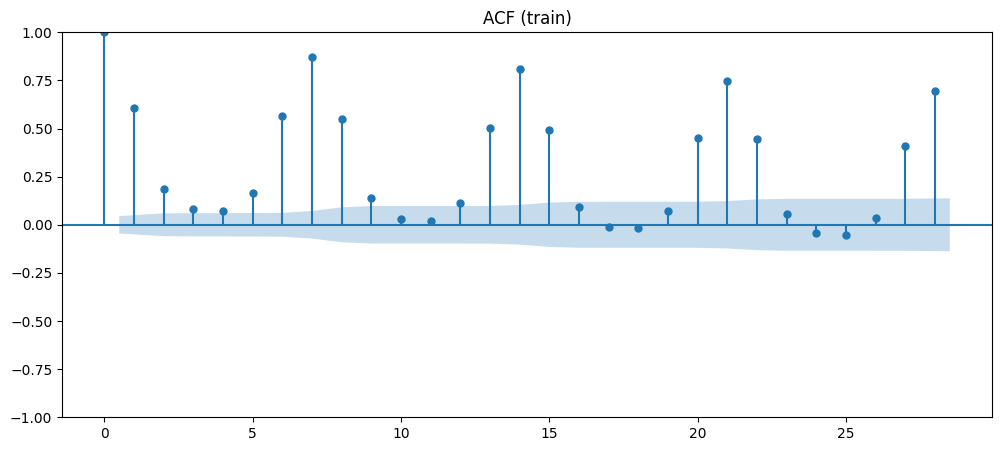

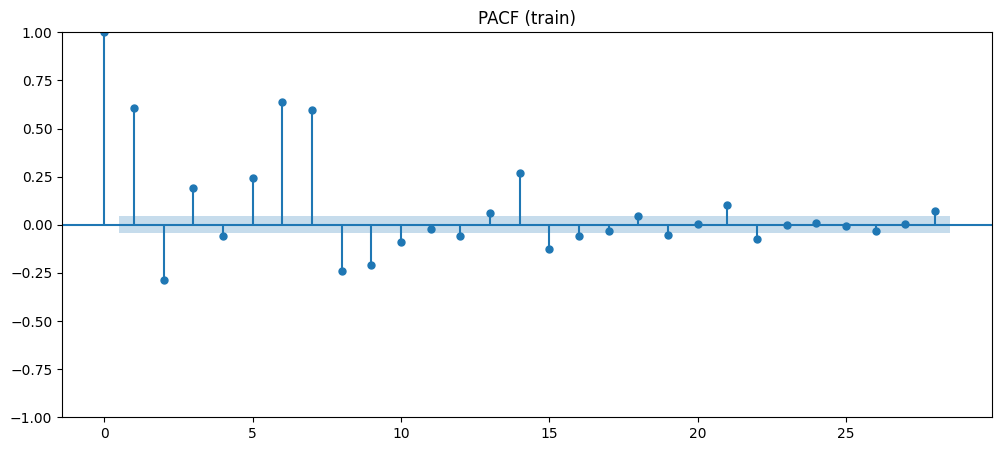

In [13]:
# plot ACF and PACF to help choose AR and MA orders
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train, lags=28); plt.title("ACF (train)"); plt.show()
plot_pacf(train, lags=28); plt.title("PACF (train)"); plt.show()

In [14]:
# fit a simple SARIMAX model with weekly seasonality
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2896      0.032      9.184      0.000       0.228       0.351
ma.L1         -0.8439      0.020    -42.877      0.000      -0.882      -0.805
ar.S.L7        0.2731      0.026     10.373      0.000       0.221       0.325
ma.S.L7       -0.9017      0.018    -50.889      0.000      -0.936      -0.867
sigma2      7.578e+07   1.01e-10   7.48e+17      0.000    7.58e+07    7.58e+07


In [15]:
# forecast next test_days and evaluate
pred = res.get_forecast(steps=test_days)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()
print("SARIMAX MAE:", mean_absolute_error(test, pred_mean))
print("SARIMAX RMSE:", np.sqrt(mean_squared_error(test, pred_mean)))

SARIMAX MAE: 14703.748137173638
SARIMAX RMSE: 24628.51960028659


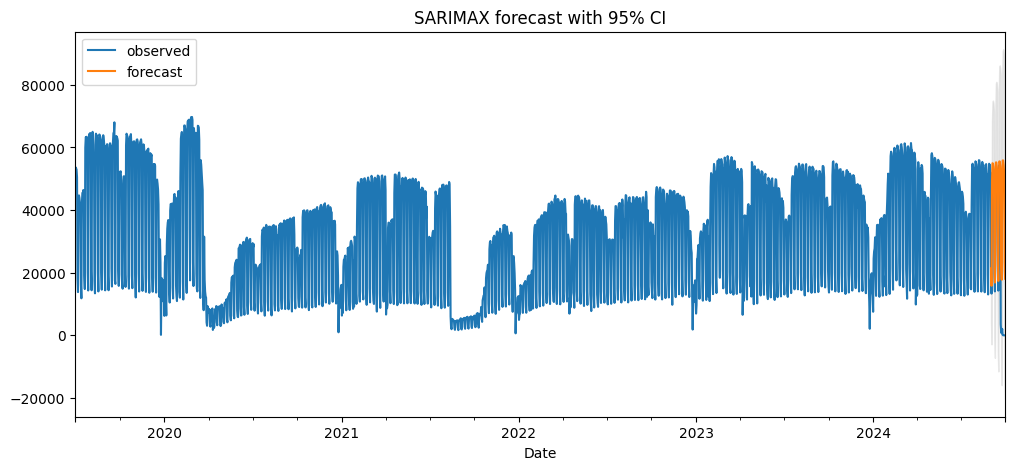

In [16]:
# plot actual vs forecast with confidence intervals
ax = daily['total_journeys'].plot(label='observed')
pred_index = pd.date_range(start=test.index[0], periods=test_days, freq='D')
pd.Series(pred_mean.values, index=pred_index).plot(ax=ax, label='forecast')
ax.fill_between(pred_index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='lightgrey', alpha=0.5)
plt.legend(); plt.title("SARIMAX forecast with 95% CI"); plt.show()


In [17]:
# residuals and simple z-score anomaly detection
residuals = test - pred_mean
z = (residuals - residuals.mean()) / residuals.std()
anoms = residuals[np.abs(z) > 2]  # threshold 2 for sensitivity
print("Anomalies detected (date -> residual):")
print(anoms)

Anomalies detected (date -> residual):
Date
2024-09-24   -55734.483430
2024-09-25   -55830.693913
Freq: D, dtype: float64


In [18]:
service_forecasts = daily[service_cols].tail(7).mean().to_frame(name='weekly_avg_per_service')
print(service_forecasts.sort_values('weekly_avg_per_service', ascending=False))

              weekly_avg_per_service
Light Rail                288.000000
Local Route                18.571429
Rapid Route                16.857143
School                      3.285714
Peak Service                0.142857
Other                       0.000000


In [19]:
# persist the fitted SARIMAX model
joblib.dump(res, "../models/sarimax_model.pkl")

['../models/sarimax_model.pkl']